# RNN on RNA K-mers

Our previous RNN used one-hot encoding per single letter.
Here we try one-hot encoding per K-mer.
For this experiment, K=3.

On the first try, this hit 15 GB RAM just building the nc_seqs tensor.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit

import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float32')  # save RAM


Load and encode the sequence data.

In [2]:
MIN_SEQ_LEN=200   ### by definition, lncRNA have min len 200
MIN_SEQ_LEN=1000  ### we use this to reduce training RAM and CPU
MAX_SEQ_LEN=25000 ### this screens 4 outliers in the complete dataset
MAX_SEQ_LEN=2000  ### we use this to reduce training RAM and CPU
DEFLINE='>'
ncfile='ncRNA.fasta' 
pcfile='pcRNA.fasta' 
#ncfile='tiny.ncRNA.fasta' # 10 seqs for faster debugging
#pcfile='tiny.pcRNA.fasta' # 10 seqs for faster debugging

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# !ls drive/'My Drive'/'Colab Notebooks'/*
ncfile='drive/My Drive/Colab Notebooks/ncRNA.fasta'
pcfile='drive/My Drive/Colab Notebooks/pcRNA.fasta'

K=2   # K-mer length = word length

# Assume file was preprocessed to contain one line per seq.
# Returned structure is ndarray of ndarray i.e no python lists inside.
def load_fasta(filename):
    seqs=[]
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE and len(line)>=MIN_SEQ_LEN and len(line)<=MAX_SEQ_LEN:
                line=line.rstrip()
                linelen=len(line)
                kmers=[]
                for i in range(linelen-K+1): # e.g. k=3,|line=4| => range=2 so i={0,1}
                    kmer=line[i:i+K]
                    kmers.append(kmer)
                kmers=np.array(kmers)
                seqs.append(kmers.reshape(-1, 1)) # reshaped changes (any,) to (any,1)
    nparray=np.array(seqs)
    return nparray

print("Load "+ncfile)
nc_seqs = load_fasta(ncfile)
print("Load "+pcfile)
pc_seqs = load_fasta(pcfile)

encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
#seq=tf.reshape(nc_seqs[0],shape=(-1, 1)) # tensor flow version
seq=nc_seqs[0].reshape(-1, 1)
encoder.fit(seq)
print("Encoder categories")
print(str(encoder.categories_))

print("Ecode the non-coding sequences")
nc_list=[]
for seq in nc_seqs:
    encoded=encoder.transform(seq)  
    nc_list.append(encoded)
    
nc_all=np.array(nc_list) # .reshape(-1,1)
print("shape: "+str(nc_all.shape))
print("sequence 0 starts ")
print(nc_seqs[0][:7])
print("element 0 encoding: ")
print(nc_all[0][:5])

print("Encode the protein-coding sequences")
pc_list=[]
for seq in pc_seqs:
    encoded=encoder.transform(seq)
    pc_list.append(encoded)

pc_all=np.array(pc_list) # .reshape(-1,1)
pc_all.shape

Mounted at /content/drive
Load drive/My Drive/Colab Notebooks/ncRNA.fasta
Load drive/My Drive/Colab Notebooks/pcRNA.fasta
Encoder categories
[array(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG',
       'GT', 'TA', 'TC', 'TG', 'TT'], dtype='<U2')]
Ecode the non-coding sequences
shape: (3761,)
sequence 0 starts 
[['TC']
 ['CA']
 ['AG']
 ['GC']
 ['CC']
 ['CT']
 ['TC']]
element 0 encoding: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Encode the protein-coding sequences


(5864,)

Create train and validation sets.

In [3]:
nc_labels=np.zeros(shape=(17711))
pc_labels=np.ones(shape=(20152))
#nc_labels=np.zeros(shape=(10))  # fast debugging
#pc_labels=np.ones(shape=(10))

#nc_labeled=np.concatenate((nc_all,nc_labels),axis=1)
#pc_labeled=np.concatenate((pc_all,pc_labels),axis=1)
all_seqs=np.concatenate((nc_all,pc_all),axis=0)
all_labels=np.concatenate((nc_labels,pc_labels),axis=0)

print("shape of sequences, shape of labels")
all_seqs.shape,all_labels.shape

splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(all_seqs):
    train_seqs =   all_seqs[train_index]
    train_labels = all_labels[train_index]
    test_seqs =    all_seqs[test_index]
    test_labels =  all_labels[test_index]
 
print("shape of train")
print(train_seqs.shape,train_labels.shape)
print("shape of test")
print(test_seqs.shape,test_labels.shape)

print("Convert numpy array to python 3D array")
def numpy_to_python_3D(np_seqs):
    one_set = []
    tlen = len(np_seqs)
    for i in range(tlen): # for every sequence in set
        one_seq = []
        slen = len(np_seqs[i])
        for j in range(slen): # for ever letter in sequence
            one_letter=np_seqs[i][j]
            one_seq.append(one_letter)
        one_set.append(one_seq)
    return one_set
train_seqs = numpy_to_python_3D(train_seqs)
test_seqs = numpy_to_python_3D(test_seqs)
train_labels = train_labels.tolist()
test_labels = test_labels.tolist()

# Now that values are shuffled, partition gives random sample.
data_size=len(train_seqs)
PARTITION=int(data_size*0.8)
print("Partition = "+str(PARTITION))

print("Partition train/validation")
X_train=train_seqs[:PARTITION]
X_valid=train_seqs[PARTITION:]
y_train=train_labels[:PARTITION]
y_valid=train_labels[PARTITION:]
print("Lengths of train,valid")
print((len(X_train),len(X_valid)))

# Free memory for the next step
nc_seqs=None
pc_seqs=None
all_seqs=None
nc_labels=None
pc_labels=None
train_seqs=None
train_labels=None

print("Convert to tensors")
tensor = tf.ragged.constant(X_train)  # This takes a long time and hogs memory
X_train = tensor
tensor=None
print(type(X_train))
print(X_train.shape)
tensor = tf.convert_to_tensor(y_train)
y_train = tensor
tensor=None
print(type(y_train))
print(y_train.shape)
tensor = tf.ragged.constant(X_valid)
X_valid=tensor
tensor=None
print(type(X_valid))
print(X_valid.shape)
tensor = tf.convert_to_tensor(y_valid)
y_valid = tensor
tensor=None
print(type(y_valid))
print(y_valid.shape)

shape of sequences, shape of labels
shape of train
(7700,) (7700,)
shape of test
(1925,) (1925,)
Convert numpy array to python 3D array
Partition = 6160
Partition train/validation
Lengths of train,valid
(6160, 1540)
Convert to tensors
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(6160, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(6160,)
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(1540, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1540,)


In [4]:
print("Build the model")
seq_len=None  # none indicates variable length
input_features=4**K   # 64 DNA K-mers at K=3
rnn2 = keras.models.Sequential([
    keras.layers.SimpleRNN(16, return_sequences=True, activation='relu', input_shape=[seq_len,input_features]),
    keras.layers.SimpleRNN(16, return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(16, return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(1),
])

print("Build the training environment")
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
rnn2.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
rnn2.summary()

Build the model
Build the training environment
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 16)          528       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 16)          528       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 16)          528       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 18        
Total params: 1,602
Trainable params: 1,602
Non-trainable params: 0
_________________________________________________________________


In [5]:
print("Train the model")
history = rnn2.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid))


Train the model
Epoch 1/5
193/193 [==============================] - 414s 2s/step - loss: 0.0117 - accuracy: 0.9933 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
193/193 [==============================] - 385s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
193/193 [==============================] - 395s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
193/193 [==============================] - 392s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
193/193 [==============================] - 391s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Visualize training history.


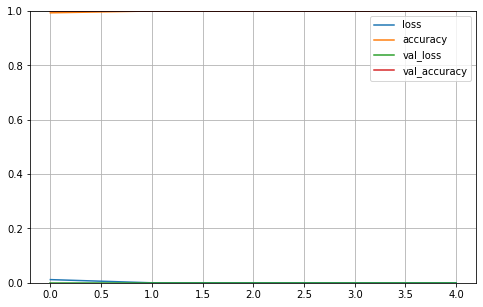

In [6]:
print("Visualize training history.")
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Resources.
[Working with RNNs](https://keras.io/guides/working_with_rnns/).
[Recurrent Neural Networks with Keras](https://www.tensorflow.org/guide/keras/rnn#rnns_with_listdict_inputs_or_nested_inputs).
Function tf.convert_to_tensor [docs](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor).
Function tf.reshape [docs](https://www.tensorflow.org/api_docs/python/tf/reshape).
Ragged Tensors [tutorial](https://www.tensorflow.org/guide/tensor#ragged_tensors)
and [docs](https://www.tensorflow.org/api_docs/python/tf/RaggedTensor#documenting_raggedtensor_shapes_2) and [module](https://www.tensorflow.org/api_docs/python/tf/ragged).
Incredible speedup for convert to tensor by sirfz on [stackoverflow](https://stackoverflow.com/questions/44353509/tensorflow-tf-constant-initializer-is-very-slow).


